# KRI EDA

This notebook contains some of the EDA done for KRI development, specifically the Adverse Event and Query related KRI scores,  as these are the crucial in modeling site risk.

## Query EDA

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
def sfl_defaults():
	plt.style.use('classic')
	plt.rcParams['figure.figsize'] = [8.0, 5.0]
	plt.rcParams['figure.facecolor']='w'

	# text size
	plt.rcParams['xtick.labelsize']=14
	plt.rcParams['ytick.labelsize']=14
	plt.rcParams['axes.labelsize']=15
	plt.rcParams['axes.titlesize']=16
	plt.rcParams['legend.fontsize']=12

	# grids
	plt.rcParams['grid.color'] = 'k'
	plt.rcParams['grid.linestyle'] = ':'
	plt.rcParams['grid.linewidth'] = 0.5
    
sfl_defaults()

df10=pd.read_csv('../../Data/c10_odm_queries.csv')
df11=pd.read_csv('../../Data/c11_odm_queries.csv')
df12=pd.read_csv('../../Data/c12_odm_queries.csv')
df13=pd.read_csv('../../Data/c13_odm_queries.csv')
df15=pd.read_csv('../../Data/c15_odm_queries.csv')

dfs=[df10, df11, df12, df13, df15]

The mean query response time is considered first, after loading in all 5 studies worh of query data, compute the amount of time it takes to close queries and average at the site level.

In [5]:
for df in dfs:
    df['ResponseTime']=pd.to_datetime(df.CloseDate)-pd.to_datetime(df.OpenDate)
    df['ResponseTimeDays']=df.ResponseTime.apply(lambda x: float(x.days))

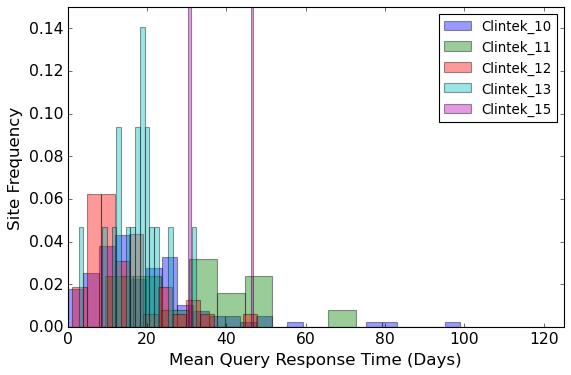

In [6]:
labels=['Clintek_10','Clintek_11','Clintek_12','Clintek_13','Clintek_15']

for df in dfs:
    df.groupby('LocationOID').ResponseTimeDays.agg('mean').plot.hist(bins=25,density=True,alpha=.4)

plt.xlabel('Mean Query Response Time (Days)')
plt.ylim([0,.15])
plt.xlim([0, 125])
plt.ylabel('Site Frequency')
plt.legend(labels)
plt.show()

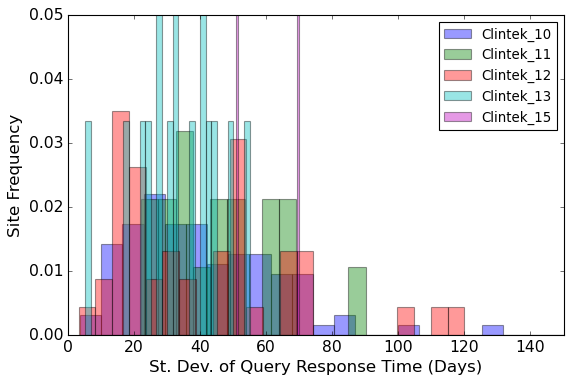

In [27]:
for df in dfs:
    df.groupby('LocationOID').ResponseTimeDays.agg(lambda x: x.std()).plot.hist(bins=30,density=True,alpha=.4)
plt.xlabel('St. Dev. of Query Response Time (Days)')
plt.xlim([0,150])
plt.ylim([0,.05])
plt.ylabel('Site Frequency')
plt.legend(labels)

(0.0, 1800.0)

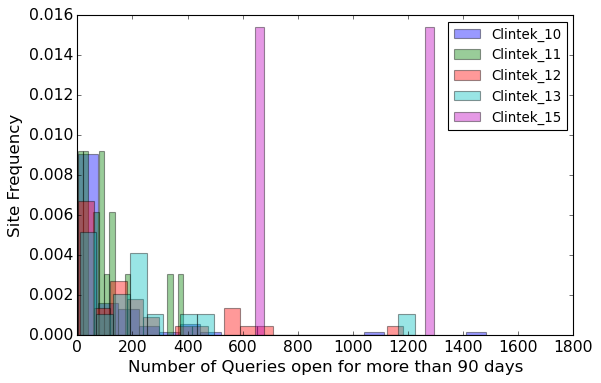

In [40]:
for df in dfs:
    df[df.ResponseTimeDays>90].groupby('LocationOID').StudyOID.agg('count').plot.hist(bins=20,density=True,alpha=.4)
plt.xlabel('Number of Queries open for more than 90 days')
plt.ylabel('Site Frequency')
plt.legend(labels)
plt.xlim([0,1800])

Next the site level query generation rate are considered.

In [ ]:
query_counts=[]

odm_sites=df10.LocationOID.unique()

for idx,time in enumerate(pd.date_range(df10.OpenDate.min(),df10.OpenDate.max(), freq='7D')):
    temp = df10[(time <= df10.OpenDate) & (df10.OpenDate < time + pd.Timedelta('7 days'))].groupby(
    'LocationOID').StudyOID.agg('count').reindex(odm_sites,fill_value=0).rename(f'period{idx}')
    
    temp=temp/ActivePatientCount(time, level='table')
    
    query_counts.append(temp)
query_rate=pd.DataFrame(query_counts).T


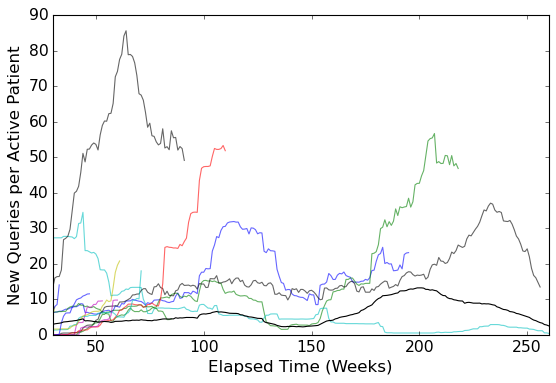

In [26]:
for row in query_rate.rolling(30,axis=1).mean().values[:15]:
    plt.plot(row,alpha=.6)
    plt.xlim([30,260])
    plt.ylabel('New Queries per Active Patient')
    plt.xlabel('Elapsed Time (Weeks)')
    
plt.plot(query_rate[query_rate < 10000].mean().rolling(30).mean().values,'k-')

In [ ]:
manual_query_counts=[]

odm_sites=df10.LocationOID.unique()

for idx,time in enumerate(pd.date_range(df10.OpenDate.min(),df10.OpenDate.max(), freq='7D')):
    temp = df10[(time <= df10.OpenDate) & 
                (df10.OpenDate < time + pd.Timedelta('7 days')) &
                (df10.QueryRecipient != 'System to Site')
               
               ].groupby(
    'LocationOID').StudyOID.agg('count').reindex(odm_sites,fill_value=0).rename(f'period{idx}')
    
    temp=temp/ActivePatientCount(time, level='table')
    
    manual_query_counts.append(temp)
manual_query_rate=pd.DataFrame(manual_query_counts).T


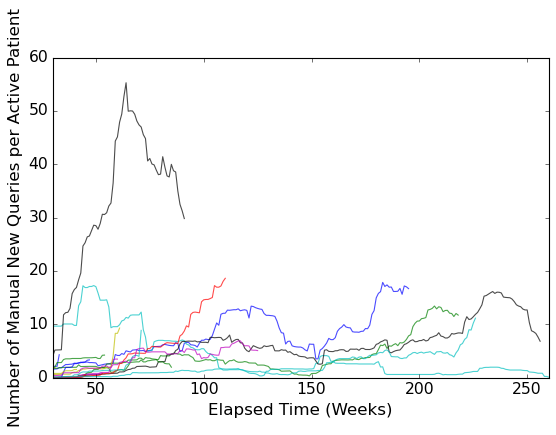

In [165]:
for row in manual_query_rate.rolling(30,axis=1).mean().values[:20]:
    plt.plot(row,alpha=.7)
    plt.xlim([30,260])
    plt.ylabel('Number of Manual New Queries per Active Patient')
    plt.xlabel('Elapsed Time (Weeks)')

In [ ]:
auto_query_counts=[]

odm_sites=df10.LocationOID.unique()

for idx,time in enumerate(pd.date_range(df10.OpenDate.min(),df10.OpenDate.max(), freq='7D')):
    temp = df10[(time <= df10.OpenDate) & 
                (df10.OpenDate < time + pd.Timedelta('7 days')) &
                (df10.QueryRecipient == 'System to Site')
               
               ].groupby(
    'LocationOID').StudyOID.agg('count').reindex(odm_sites,fill_value=0).rename(f'period{idx}')
    
    temp=temp/ActivePatientCount(time, level='table')
    
    auto_query_counts.append(temp)

auto_query_rate=pd.DataFrame(auto_query_counts).T


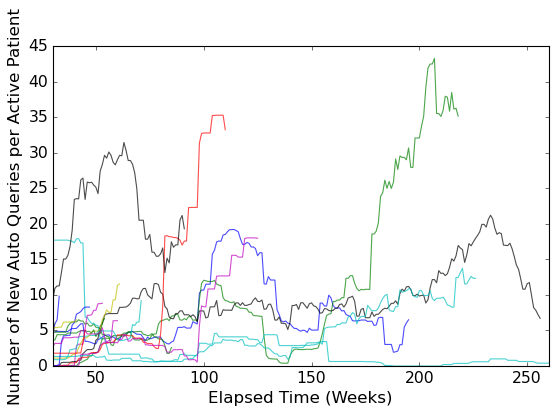

In [166]:
for row in auto_query_rate.rolling(30,axis=1).mean().values[:20]:
    plt.plot(row,alpha=.7)
    plt.xlim([30,260])
    plt.ylabel('Number of New Auto Queries per Active Patient')
    plt.xlabel('Elapsed Time (Weeks)')

## Adverse Event Rates

Similar analysis is performed on the AE tables

In [89]:
lst=[]

step=1

for day in range(0, 200, step):
    patient_count = df[(day <= df.AESTDY) & (df.AESTDY < day + step)].groupby(['Site','USUBJID']).DOMAIN.agg('count')
    site_count = patient_count.groupby('Site').agg('sum')
    site_count_index_fix = site_count.reindex(sites, fill_value=0).rename(f'{day}')
    
    site_rate = site_count_index_fix/ActivePatientCount(day, level='table')
    
    lst.append(site_rate.fillna(0))
    
AE_time_count=pd.DataFrame(lst).T

AE_mean=AE_time_count[(AE_time_count>0) & (AE_time_count<1000)].fillna(.05).mean()

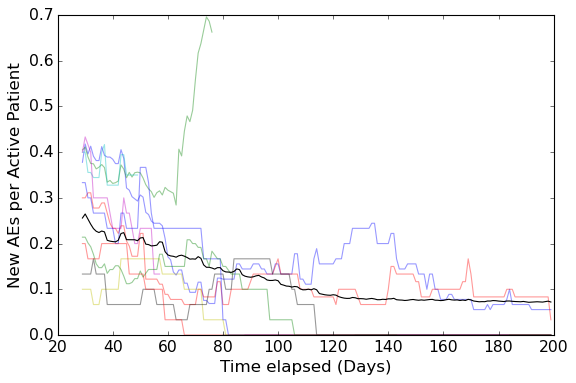

In [94]:
for seq in AE_time_count.rolling(30,axis=1).mean().values[:10]:
    plt.plot(seq,alpha=.4)
    plt.xlabel('Time elapsed (Days)')
    plt.ylabel('New AEs per Active Patient')

plt.plot(AE_mean.rolling(30).mean().values,'k')

Including the cumulative AE totals per site was considered, however the data was not properly normaized: larger sites had more AEs, so the cumulative total measured site size, not risk.

In [138]:
lst=[]

step=7

for day in range(0, 300, step):
    ser_patient_count = df[(day <= df.AESTDY) & (df.AESTDY < day + step) & (df.AESER == 'Y')].groupby(['Site','USUBJID']).DOMAIN.agg('count')
    ser_site_count = ser_patient_count.groupby('Site').agg('sum')
    ser_site_count_index_fix = ser_site_count.reindex(sites, fill_value=0).rename(f'{day}')
    
    ser_site_rate = ser_site_count_index_fix/ActivePatientCount(day, level='table')
    
    lst.append(ser_site_rate.fillna(0))
    
SAE_time_count=pd.DataFrame(lst).T

SAE_mean=SAE_time_count[(SAE_time_count>0) & (SAE_time_count<1000)].fillna(.05).mean()

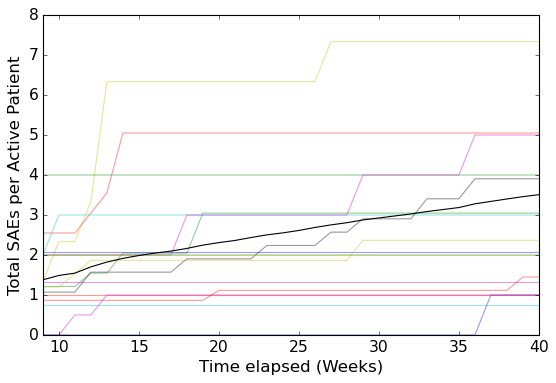

In [148]:
for seq in SAE_time_count.values[30:50]:
    plt.plot(seq.cumsum(),alpha=.4)
    plt.xlabel('Time elapsed (Weeks)')
    plt.ylabel('Total SAEs per Active Patient')
    plt.xlim([9,40])

plt.plot(SAE_mean.values.cumsum(),'k')

The number of SAEs was found to be a strong indicator of risk; sites are split into two groups (see the plot below, the split value occurs at 10).

Text(0, 0.5, 'Count')

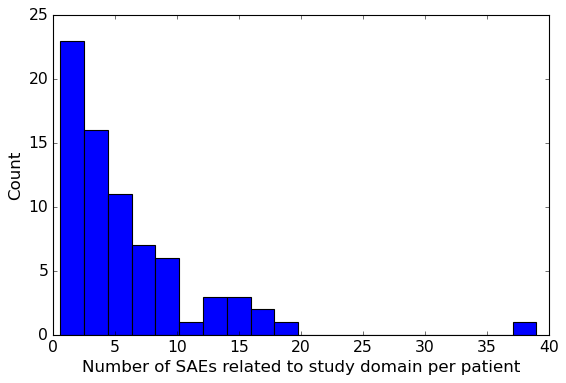

In [166]:
(df[(df.AEREL == 'RELATED') & (df.AESER)].groupby('Site').STUDYID.agg('count')/ActivePatientCount(0,level='table')).plot.hist(bins=20)
plt.xlabel('Number of SAEs related to study domain per patient')
plt.ylabel('Count')